##  Table of Contents
<a id='Table of contents'></a>

### <a href='#1. Introduction'> 1. Introduction </a>

### <a href='#2. Hypothesis'> 2. Hypothesis </a>

### <a href='#3. Exploratory Data Analysis and Feature Engineering'> 3. Exploratory Data Analysis and Feature Engineering </a>
* <a href='#3.1. Data Cleaning'> 3.1. Data Cleaning </a>
* <a href='#3.2. Feature Engineering'> 3.2. Feature Engineering </a>
* <a href='#3.3. Feature Selection'> 3.3. Feature Selection </a>
* <a href='#3.4. Standardization'> 3.4. Standardization </a>
* <a href='#3.5. Principal Component Analysis'> 3.5. Principal Component Analysis </a>

### <a href='#4. Clustering'> 4. Clustering</a>
* <a href='#4.1. Mean shift'> 4.1. Mean Shift </a>
* <a href='#4.2. DBSCAN Clustering'> 4.2. DBSCAN Clustering </a>
* <a href='#4.3. K-Means Clustering'> 4.3. K-Means Clustering </a>
* <a href='#4.4. Results'> 4.4. Results </a>

### <a href='#5. Time Series Analysis'> 5. Time Series Analysis </a>
* <a href='#5.1. ARIMA'> 5.1. ARIMA </a>
* <a href='#5.2. Prophet'> 5.2. Prophet </a>
* <a href='#5.3. Results'> 5.3. Results </a>

### <a href='#6. Discussion and Recommendations'> 6. Discussion and Recommendations </a>
* <a href='#6.1. Business Insights'> 6.1. Business Insights </a>
* <a href='#6.2. Recommendations for Further Analysis'> 6.2. Recommendations for Further Analysis </a>

In [1]:
import numpy as np
from numpy import log
import pandas as pd
import image
import re
import os
import random
import datetime
import csv
import folium
import pickle
import scipy
from scipy.stats import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics, model_selection
#from sklearn.metrics import silhouette_sample
from sklearn.datasets import make_blobs
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from statsmodels.tsa.arima_model import ARIMA  
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs,  nsdiffs
from fbprophet import Prophet
from IPython.display import HTML
import logging
from collections import OrderedDict, defaultdict
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings('ignore')   
start_time=datetime.datetime.now()

<a id='1. Introduction'></a>
*****

# 1. Introduction

For my final capstone I will forecast daily ridership for the Bay Area Rapid Transit system. I will provide ridership predictions for both the system as a whole as well as individual stations. Predicting daily trip counts could be used to inform staff scheduling as well as myriad other decisions that are influenced by ridership numbers. This information would be valuable because it would allow BART management to allocate staffing resources effectively. Overstaffing creates unneeded expenses and understaffing can cause service issues such as long lines, dirty stations, maintenance problems and delays.

The ability to accurately make such predictions would be particularly useful over the next few months as ridership recovers from the drastic reduction caused by COVID-19 and the resulting “shelter-in-place” orders.

<a id='2. Hypothesis'></a>
*****

# 2. Hypothesis

Despite COVID-19 related disruptions I anticipate there will be enough of a discernible trend and seasonality in the ridership data to allow for effective forecasting. 

My hypothesis is that time series analysis will be able to forecast one month out from the last available sample while achieving +/-10% accuracy for at least 80% of predictions.

<a id='3. Exploratory Data Analysis and Feature Engineering'></a>
*****

# 3. Exploratory Data Analysis and Feature Engineering

According to the BART website the data I will be using "represents BART ridership by origin and destination (O-D) pairs...and contains five columns representing Day, Hour, Origin Station, Destination Station, and Trip Count."

The data is stored in separate files for each year, I've created a function to read them into pandas and create features that extract information from the timestamp, such as whether a given sample is during the morning or evening commute, weekday or weekend, etc

Ridership Data Overview Page: https://www.bart.gov/about/reports/ridership

Hourly Ridership Data: http://64.111.127.166/origin-destination/

In [2]:
def prepare_df(file):
    temp_df=pd.read_csv(file, names=['datetime', 'hour','origin','destination', 'trip_count'])
    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_df['month'] = temp_df['datetime'].dt.month
    temp_df['day'] = temp_df['datetime'].dt.day_name()
    return temp_df

In [3]:
# I will create a dictionary to store the dataframes for each year of data
df_dict={}
for i in [2018, 2019, 2020]:
    file_name=(f"date-hour-soo-dest-{i}.csv")
    df_dict.update({f"df_{i}":prepare_df(file_name)})
df_dict.keys()

dict_keys(['df_2018', 'df_2019', 'df_2020'])

In [4]:
df_dict['df_2020'].head()

datetime  hour origin destination  trip_count  month        day
0 2020-01-01     0   12TH        16TH           5      1  Wednesday
1 2020-01-01     0   12TH        24TH           3      1  Wednesday
2 2020-01-01     0   12TH        ASHB           6      1  Wednesday
3 2020-01-01     0   12TH        BAYF           1      1  Wednesday
4 2020-01-01     0   12TH        CIVC           3      1  Wednesday

In [5]:
# BART also provides a seperate file with station data, which includes station latitude/longitude and full name
stations = pd.read_csv('station_info.csv', encoding = "ISO-8859-1")
stations_dict=stations.set_index('Abbreviation')['Name'].to_dict()

Lets take a look at the total trip counts for the system as a whole over the last three years

df_2018


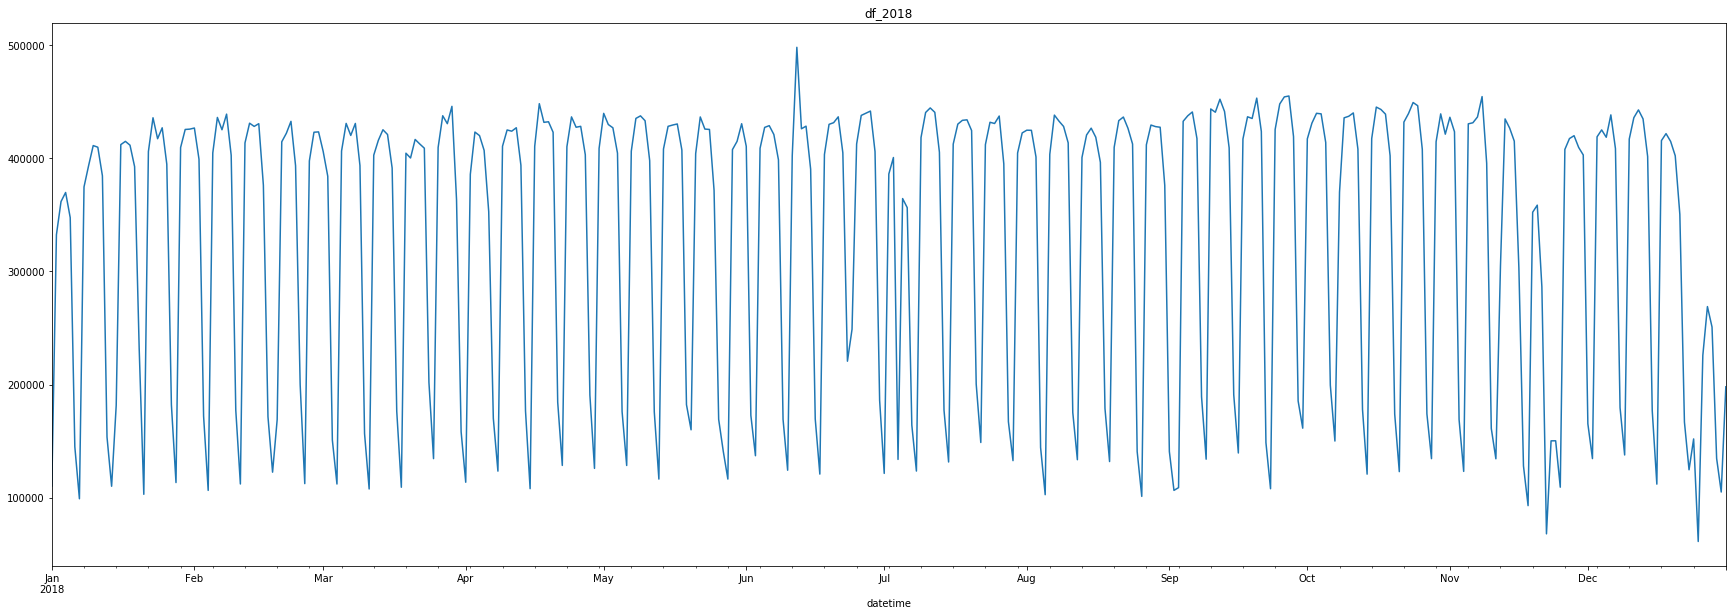

df_2019


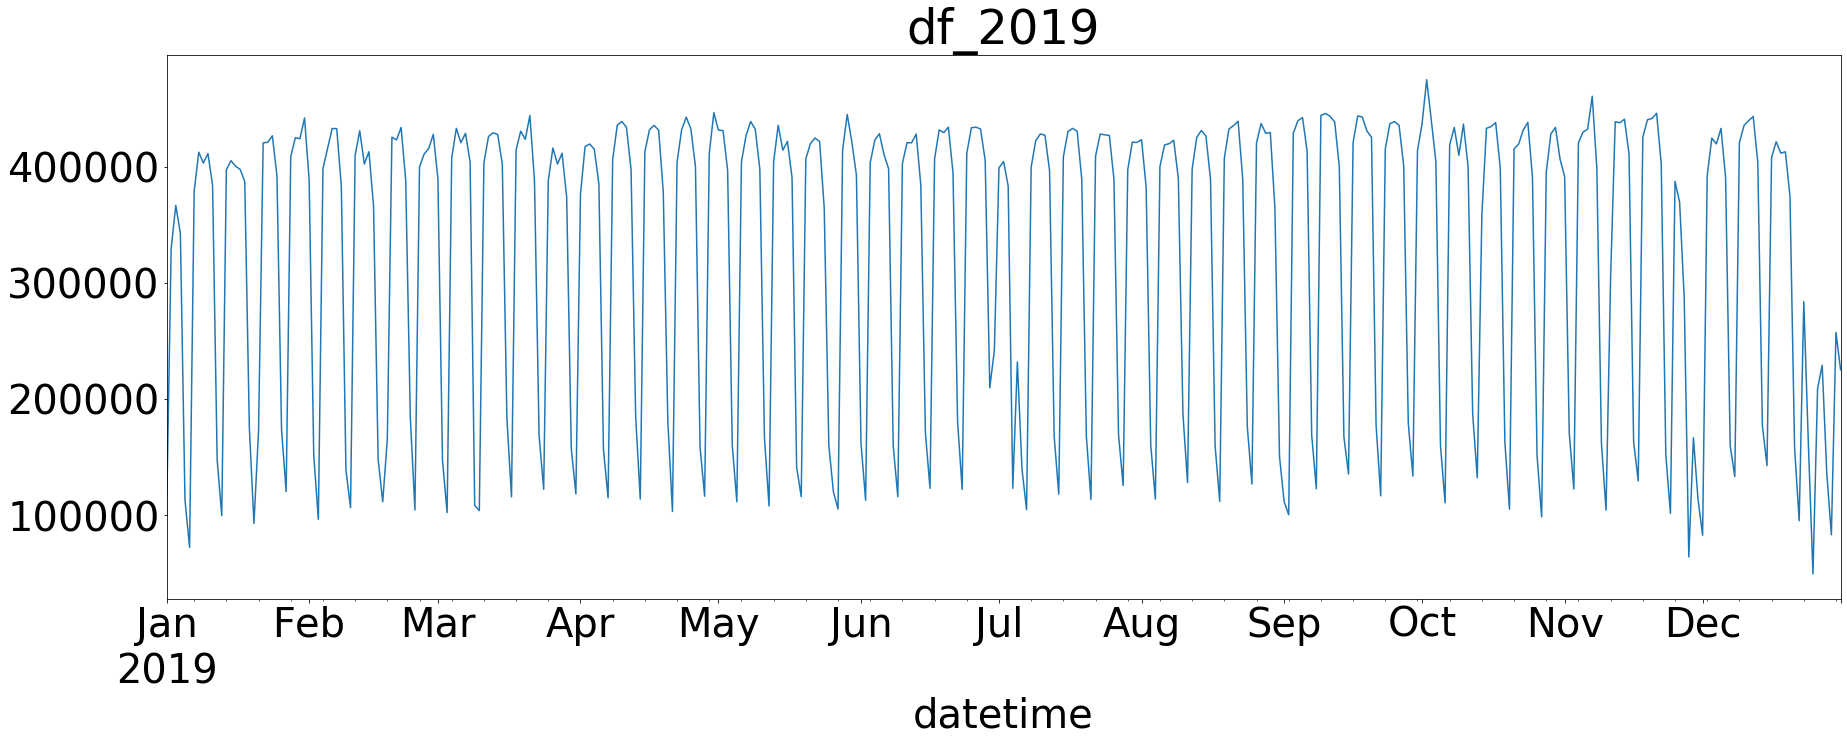

df_2020


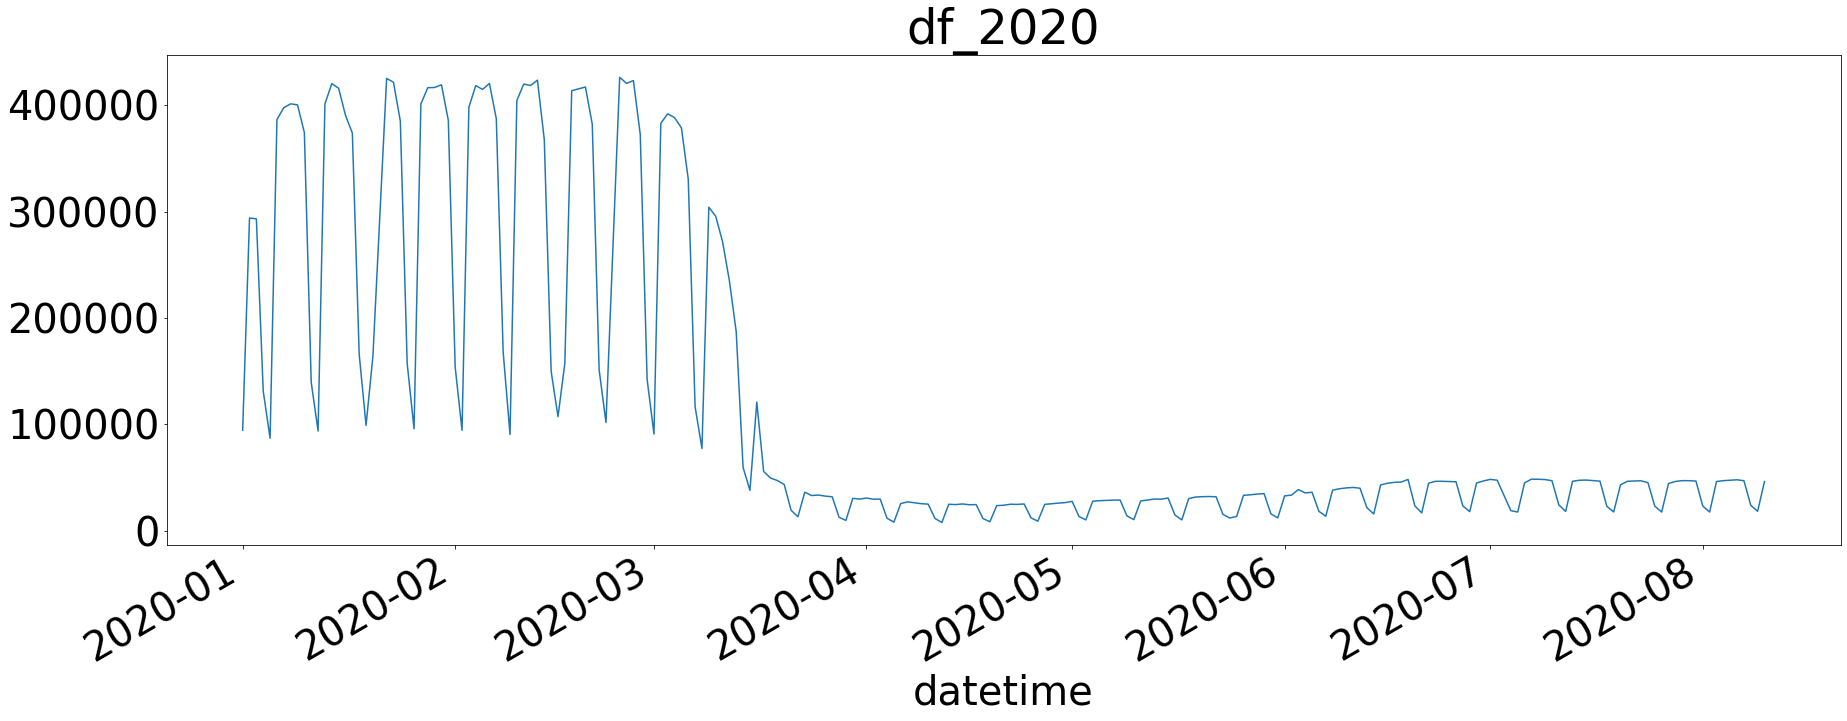

In [6]:
for i in df_dict:
    (df_dict[i].groupby('datetime').sum()['trip_count']).plot(figsize=[30, 10])
    print(i)
    plt.title(i)
    plt.rc('font', size=40) 
    plt.show()

Unsurprisingly there is a sudden decrease in trip counts starting in mid March 2020. San Francisco declared a local emergency due to the coronavirus outbreak on February 25th, by March 16, 2020 California Governor Gavin Newsom had ordered all bars, nightclubs, wineries, and brewpubs to close and San Francisco had announced a "shelter in place" order. Trip counts have been a fraction of their historical average since then. 

https://www.gov.ca.gov/2020/03/04/governor-newsom-declares-state-of-emergency-to-help-state-prepare-for-broader-spread-of-covid-19/

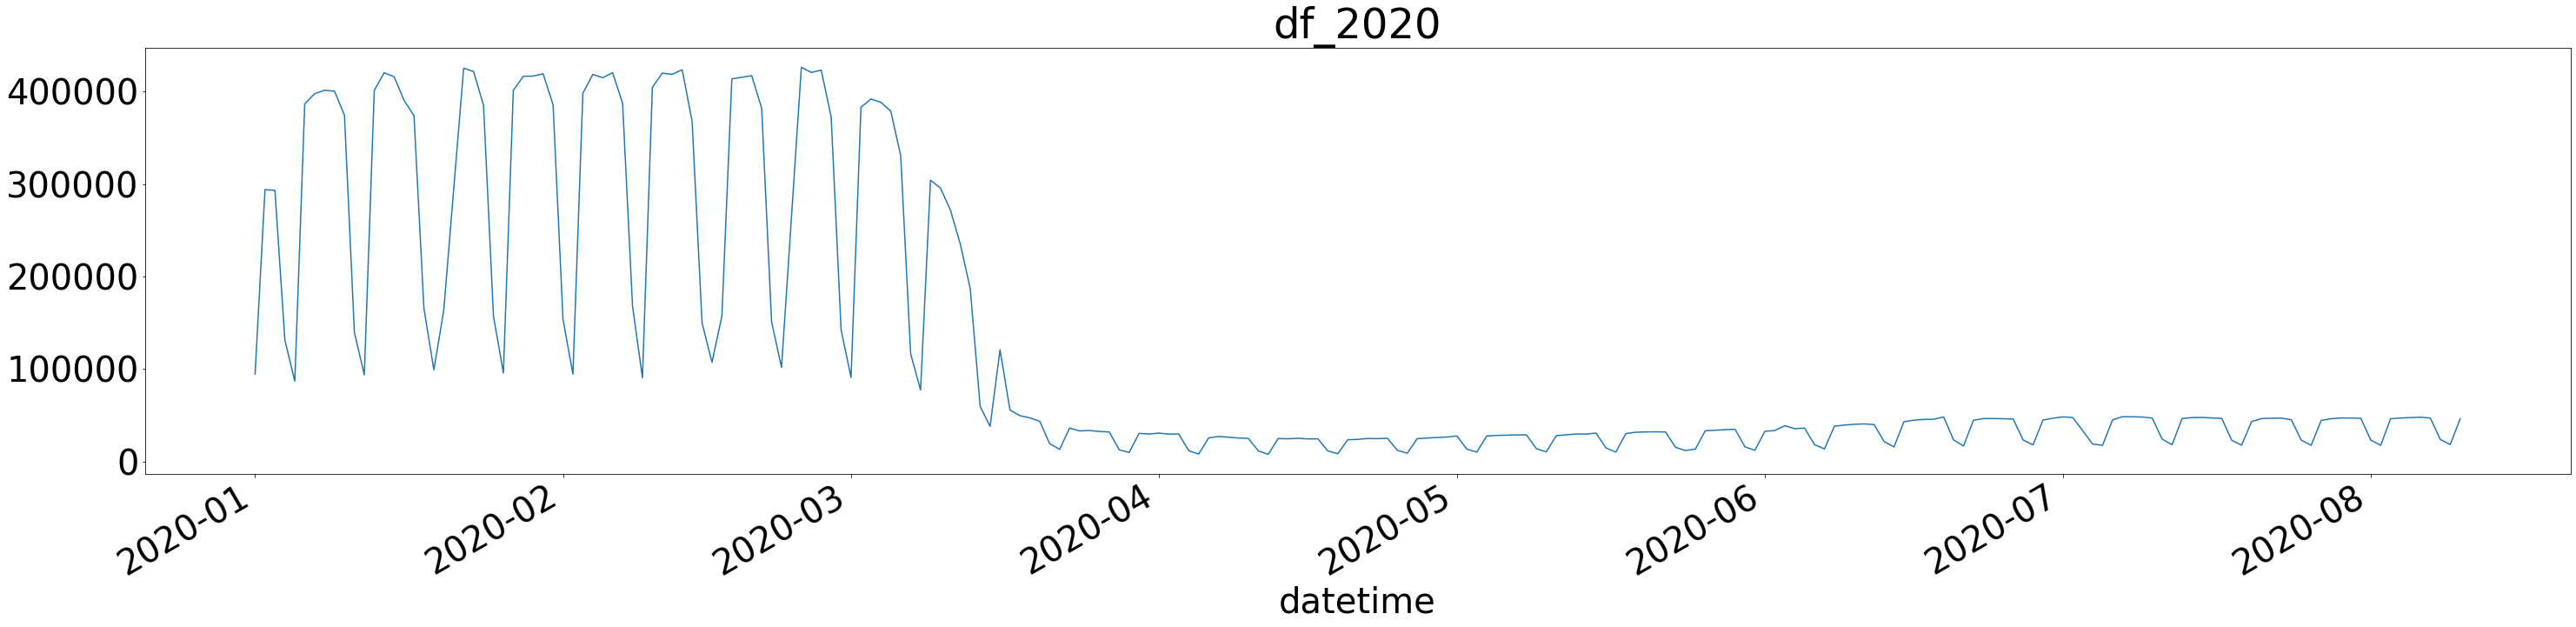

In [7]:
(df_dict['df_2020'].groupby('datetime').sum()['trip_count']).plot(figsize=[50, 10])
plt.title('df_2020')
plt.show()

Despite the major changes in ridership due to COVID-19 there is a clear weekly seasonality that has persisted. Both before and after the emergence of COVID-19 there is a consistent pattern of weekends experiencing lower trip counts than weekdays. We can observe the same weekly seasonality by plotting the average trip counts for each day of the week. 

In [8]:
weekly_traffic=df_dict[i].groupby('day').sum()['trip_count']
weekly_traffic=weekly_traffic.reindex(['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

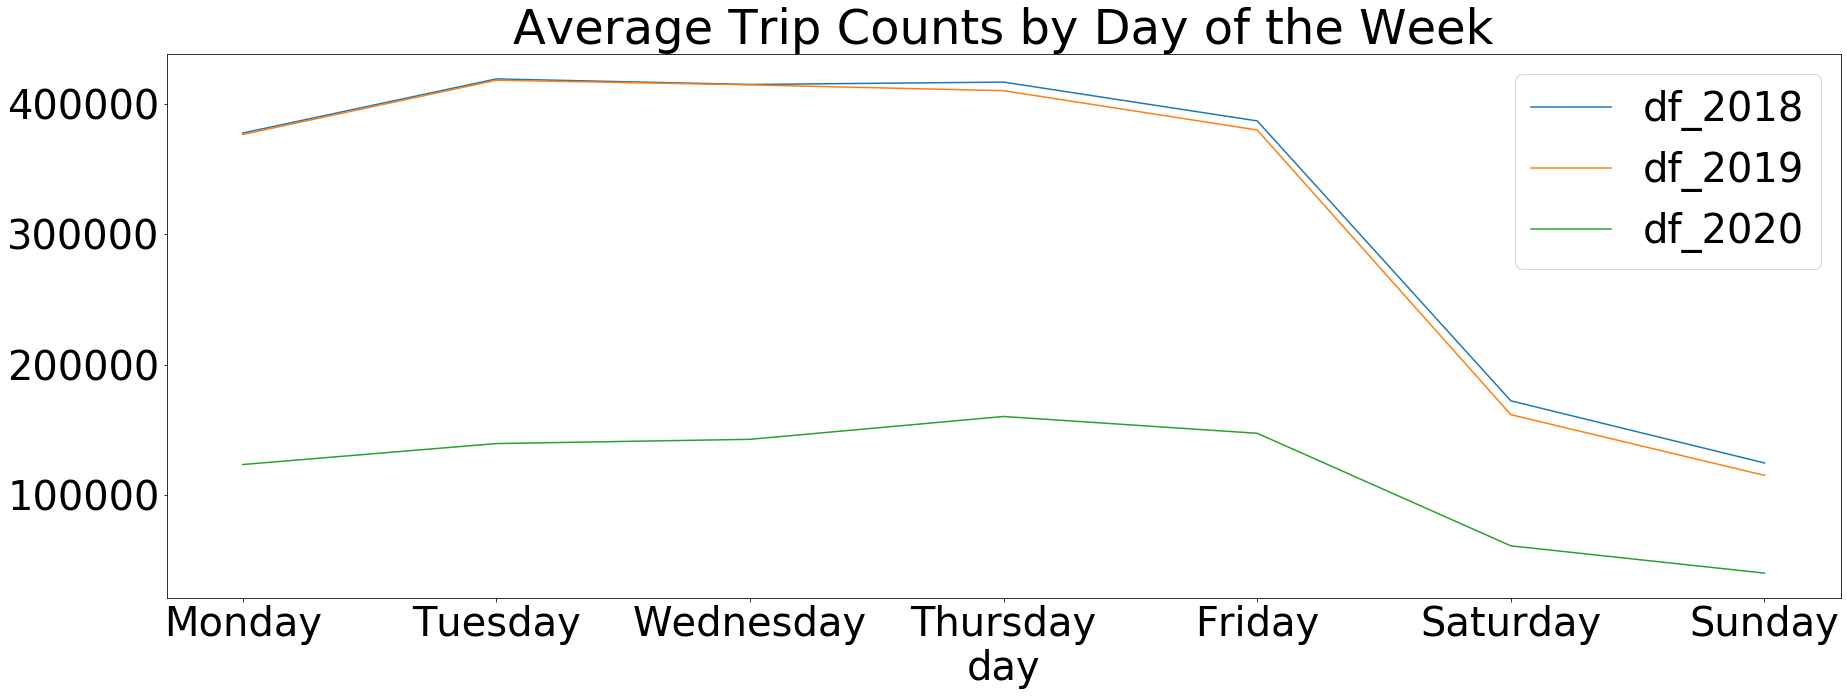

In [9]:
# column with integers for weekdays, put in order, relabel when plotting
for i in df_dict:
    weekly_traffic=df_dict[i].groupby('day').sum()['trip_count']/df_dict[i]['datetime'].dt.date.unique().shape[0]*7
    weekly_traffic=weekly_traffic.reindex(['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    weekly_traffic.plot(figsize=[30, 10])
plt.title('Average Trip Counts by Day of the Week')
plt.legend(df_dict)
plt.show()


There is also a clear hourly seasonality, with increased trip counts during "rush hour" periods centered around 8am and 5pm.

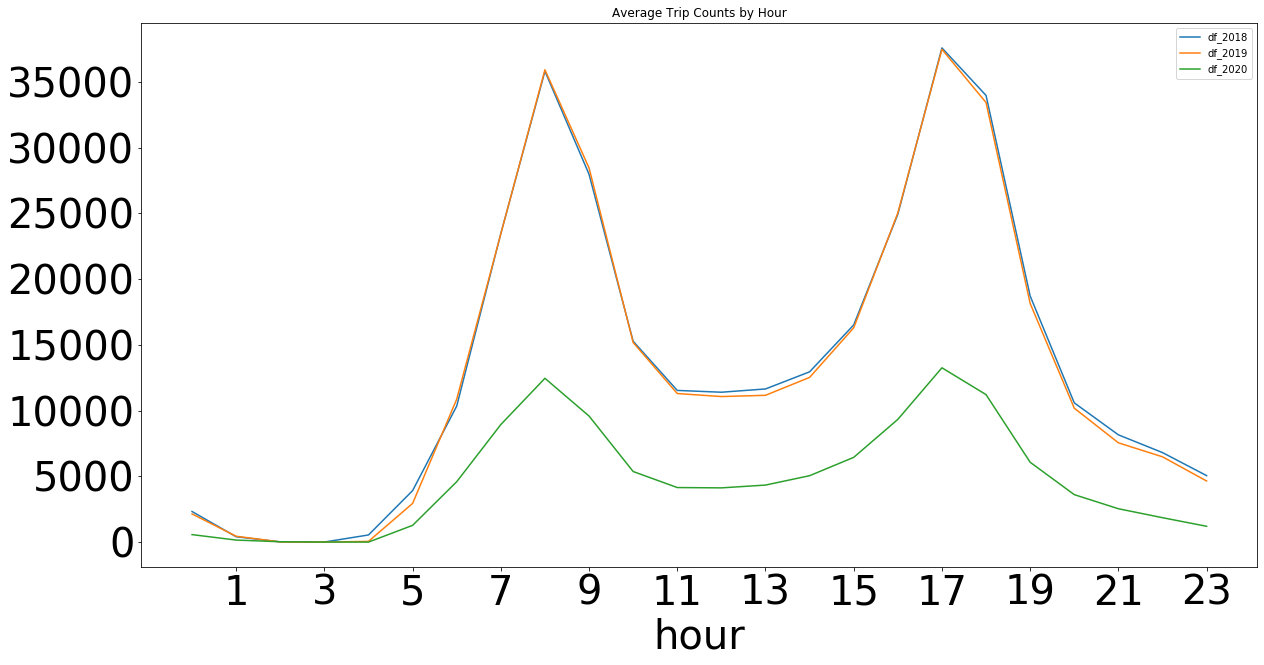

In [10]:
for i in df_dict:
    (df_dict[i].groupby('hour').sum()['trip_count']/df_dict[i]['datetime'].dt.date.unique().shape[0]).plot(figsize=[20, 10], xticks=[x for x in range(1, 24, 2)])
    plt.title('Average Trip Counts by Hour')
    plt.rc('font', size=10) 
plt.legend(df_dict)
plt.show()    

Monthly seasonality is less pronounced. Trip counts are generally lower in February and higher in October, but it is difficult to offer broad generalizations.

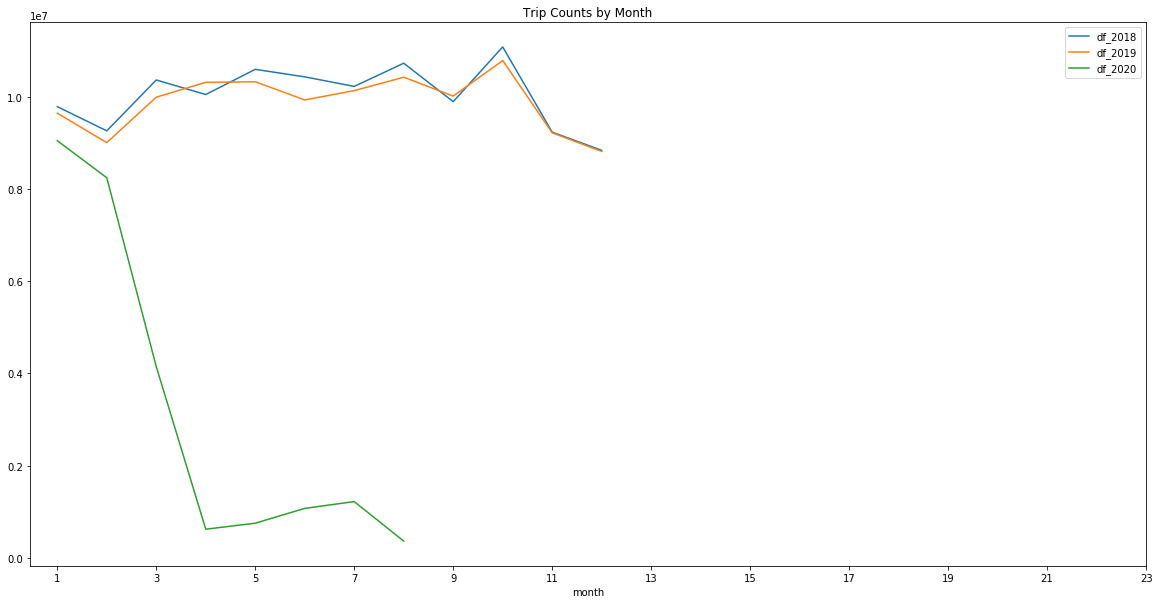

In [11]:
for i in df_dict:
    (df_dict[i].groupby('month').sum()['trip_count']).plot(figsize=[20, 10], xticks=[x for x in range(1, 24, 2)])
    plt.title('Trip Counts by Month')
    plt.rc('font', size=10) 
plt.legend(df_dict)
plt.show()    

Since my objective is to predict ridership in the near future I will limit the data analyzed to samples that were collected after 04-12-2020. This is approximately when ridership bottomed out after a rapid decline starting in March.

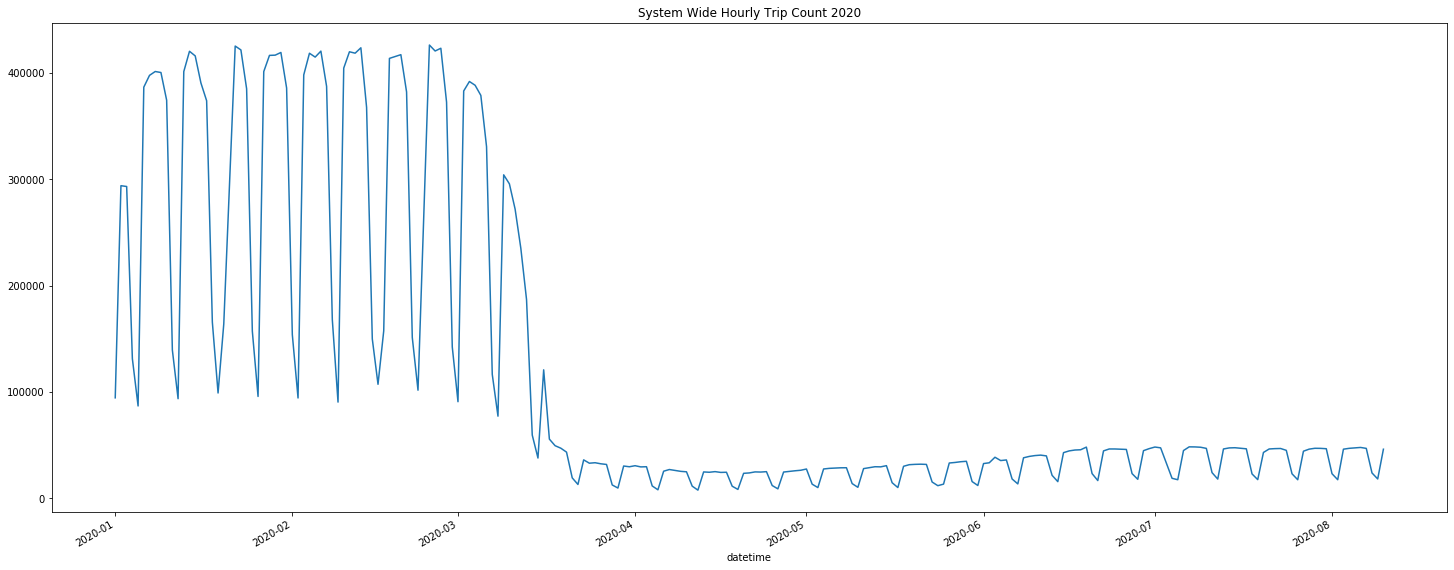

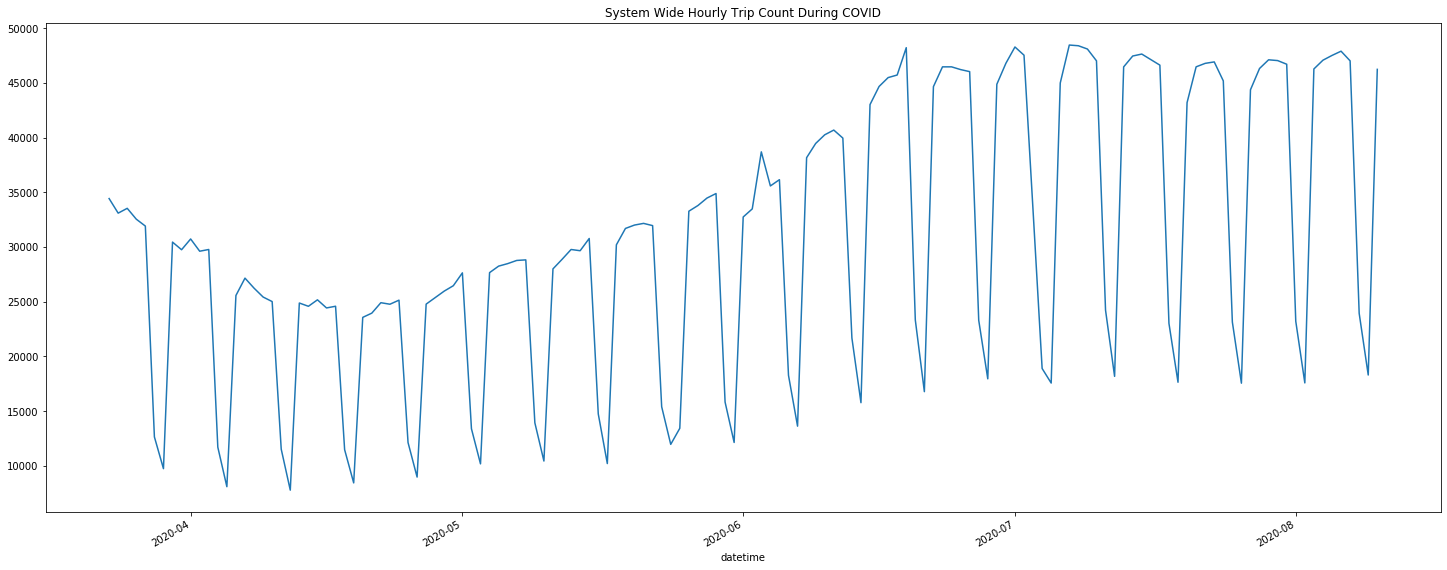

In [12]:
df_dict['df_2020'].groupby('datetime').sum()['trip_count'].plot(figsize=[25,10])
plt.title('System Wide Hourly Trip Count 2020')
plt.show()
df_COVID=df_dict['df_2020'].loc['2020-04-12 00:00:00':]
df_COVID.groupby('datetime').sum()['trip_count'].plot(figsize=[25,10])
plt.title('System Wide Hourly Trip Count During COVID')
plt.show()

In order to do station-level analysis I will aggregate the data we have about each station.

In [13]:
#The function defined below generates station-level aggregate data from the raw dataset
def create_agg_df(temp_df):    
    temp_df['morning_commute']=((temp_df['hour']>=5) & (temp_df['hour']<= 12))
    temp_df['evening_commute']=((temp_df['hour']>12) & (temp_df['hour']<= 20))
    temp_df['after_hours']=((temp_df['morning_commute']==False) & (temp_df['evening_commute']==False))
    temp_df['weekend']=((temp_df['day'] == 'Saturday') | (temp_df['day'] == 'Sunday'))

    total_trips_dict={}
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2['trip_count'].sum()
        total_trips_dict.update({i:trip_count})

    morning_commutes_dict={}
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2[temp_df['morning_commute']==True]['trip_count'].sum()
        morning_commutes_dict.update({i:trip_count})

    evening_commutes_dict={}
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2[temp_df['evening_commute']==True]['trip_count'].sum()
        evening_commutes_dict.update({i:trip_count})

    after_hours_dict={}
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2[temp_df['after_hours']==True]['trip_count'].sum()
        after_hours_dict.update({i:trip_count})

    weekday_dict={}
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2[temp_df['weekend']==False]['trip_count'].sum()
        weekday_dict.update({i:trip_count})

    weekend_dict={}
    full_name_list=[]
    for i in temp_df['origin'].unique():
        temp_df2=temp_df[temp_df['origin']==i]
        trip_count=temp_df2[temp_df['weekend']==True]['trip_count'].sum()
        weekend_dict.update({i:trip_count})
        try:
            full_name_list.append(stations_dict[i])
        except:
            full_name_list.append(i)
    
    df_agg=pd.DataFrame.from_dict(total_trips_dict, orient='index', dtype=None)
    df_agg.columns=['total_trips']
    df_agg['morning_commute']=pd.DataFrame.from_dict(morning_commutes_dict, orient='index', dtype=None)
    df_agg['evening_commute']=pd.DataFrame.from_dict(evening_commutes_dict, orient='index', dtype=None)
    df_agg['after_hours']=pd.DataFrame.from_dict(after_hours_dict, orient='index', dtype=None)
    df_agg['weekday']=pd.DataFrame.from_dict(weekday_dict, orient='index', dtype=None)
    df_agg['weekend']=pd.DataFrame.from_dict(weekend_dict, orient='index', dtype=None)
    df_agg['station_name']=full_name_list
    df_agg.sort_index(inplace=True)
    
    return df_agg

In [14]:
df_agg_COVID=create_agg_df(df_COVID)

<a id='4. Clustering'></a>
******

# 4. Clustering

I will evaluate three different clustering algorithms before selecting one for closer analysis. The algorithms I will utilize are mean shift, DBSCAN and k-means. 

I will use silhouette scores to determine how successful each clustering algorithm is. The silhouette score indicates how similar a station is to its own cluster (cohesion) compared to other clusters (separation). The score ranges from −1 to +1, with a high value indicating stations are well matched to their cluster and poorly matched to neighboring clusters. Low or negative values indicate the model may have too many or too few clusters.

In [15]:
feature_list=['total_trips', 'morning_commute', 'evening_commute', 'after_hours',
       'weekday', 'weekend']
df=df_agg_COVID[feature_list]
#df.head()

<a id='3.1. Data Cleaning'></a>

In [16]:
#I found that the clustering was more succesful when I converted time of day/time of week counts to percentages of all trip counts
for feature in feature_list[1:]:
    df[feature]=df[feature]/df['total_trips']

We'll scale the data so that the feature importance isn't distorted by differences in scale

In [17]:
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
standardizer.fit(df[feature_list])
std_x = standardizer.transform(df[feature_list])
std_df = pd.DataFrame(std_x,columns=feature_list)
std_df.head()

total_trips  morning_commute  evening_commute  after_hours   weekday  \
0     0.597745        -0.815271         0.876661    -0.520197  0.224890   
1     1.161788        -1.494996         1.474440     0.689451 -0.286840   
2     0.203106        -0.704257         0.747656    -0.330463  0.270434   
3     0.986536        -0.819980         0.888274    -0.604036 -0.176136   
4    -0.419382         1.866433        -1.987514     0.950666  1.315900   

    weekend  
0 -0.224890  
1  0.286840  
2 -0.270434  
3  0.176136  
4 -1.315900

In order to facilitate visualization I will apply two component PCA to the data 

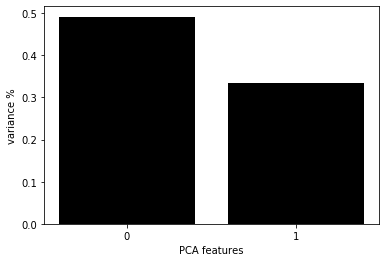

In [18]:
temp_df=std_df
X_std = StandardScaler().fit_transform(temp_df)# Create a PCA instance: pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

<a id='4.1. Mean shift'></a>
***

**4.1. Mean shift**

Since this dataset is relatively small it makes sense to start with mean shift, which is computationally expensive but will provide useful insights into the data.  Mean shift automatically determines the number of clusters it uses based on its evaluation of the data. This will provide a general sense of the range of cluster numbers we should try for other algorithms. We will be using the "estimate_bandwidth" function that is contained in the mean shift package. The "quantile" value influences the number of clusters that the algorithm chooses so we will try several values and compare results.

In [19]:
# We'll create a custom function so that we can efficiently run the same code with different hyperparameters 
def compute_meanshift(data, quantile_val, print_comparison='No', user_labels=None):
    from sklearn.cluster import MeanShift, estimate_bandwidth

    # Here we set the bandwidth. This function automatically derives a bandwidth
    # number based on an inspection of the distances among points in the data.
    bandwidth = estimate_bandwidth(data, quantile=quantile_val)
    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data)
    # Extract cluster assignments for each data point.
    labels = ms.labels_
    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_
    # Count our clusters.
    n_clusters_ = len(np.unique(labels))
    silh_score=metrics.silhouette_score(data, labels)
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    
    if print_comparison == 'No':
        plt.title(f"Quantile: {quantile_val}\nNumber of estimated clusters: {n_clusters_}\nSilhouette Score: {silh_score:.2f}")

    #plt.show()
    if print_comparison != 'No':
        print('Compare the assigned clusters to the labels in the data:')
        print(pd.crosstab(user_labels,labels))

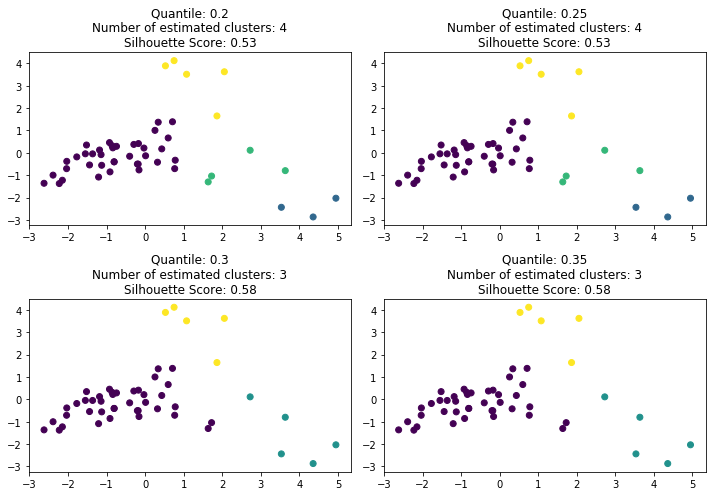

In [20]:
fig = plt.figure(figsize=[10, 7])
quantile_vals=[.2, .25, .3, .35]
ax_list=[1, 2, 3, 4]
for quantile_val, ax in zip(quantile_vals, ax_list):
    plt.subplot(2, 2, ax)
    compute_meanshift(data=principalComponents, quantile_val=quantile_val)
fig.tight_layout()
plt.show()

It appears that a quantile values of .3 and .35 produce the highest silhouette scores and a reasonable number of clusters. The mean-shift algorithm identified three clusters with these parameter selections. Let's evaluate other clustering methods with these results in mind.

<a id='4.2. DBSCAN Clustering'></a>
***

**4.2. DBSCAN Clustering**

Another clustering method worth exploring is DBSCAN. DBSCAN is very sensitive to the density of clusters and will not assign a point to a cluster if the resulting cluster would be insufficiently dense. Evaluating the number of stations that are not assigned to a cluster will provide us with insight into our data whether or not we end up using DBSCAN as our final model.

In [21]:
# We'll create a custom function so that we can efficiently run the same code with different hyperparameters 
def compute_DBSCAN(data, eps_val, min_sample_val):
    # Compute DBSCAN
    db = DBSCAN(eps=eps_val, min_samples=min_sample_val).fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = data[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title(f"\n\neps={eps_val} min_sample={min_sample_val}\n\nNumber of clusters: {n_clusters_}\nNumber of noise points: {n_noise_}\nSilhouette Score: {metrics.silhouette_score(data, labels):.2f}")
    
def plot_DBSCAN(df, eps):
    fig = plt.figure(figsize=[10, 8])
    min_sample_values=[1, 2, 3, 4]
    ax_list=[1, 2, 3, 4]
    for samples, ax in zip(min_sample_values, ax_list):
        try:
            plt.subplot(2, 2, ax)
            compute_DBSCAN(df, eps_val= eps, min_sample_val= samples)
        except:
            z=1
    fig.tight_layout()
    plt.show()

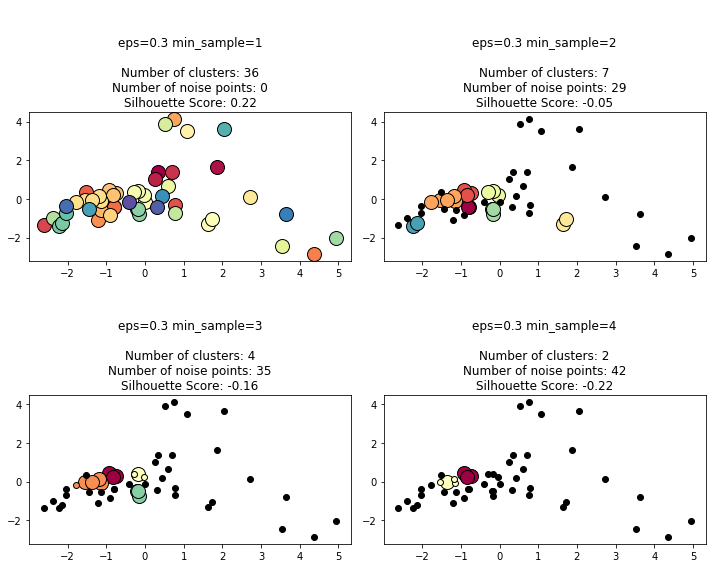

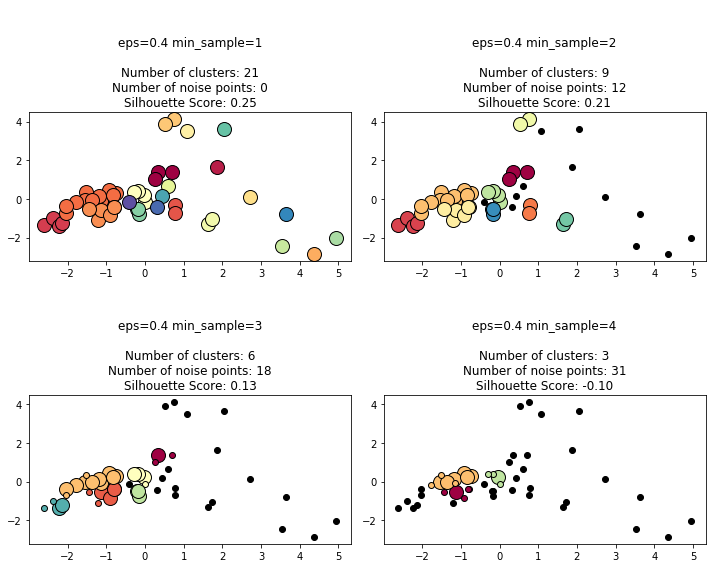

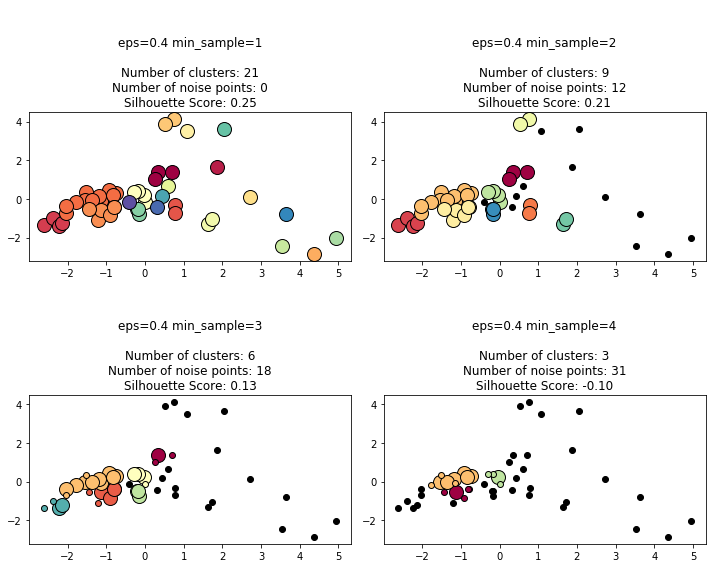

In [22]:
plot_DBSCAN(principalComponents, eps=.3)
plot_DBSCAN(principalComponents, eps=.4)
plot_DBSCAN(principalComponents, eps=.4)

DBSCAN does not appear to perform well on this data until it produces a rather large number of clusters. I expect that a lower number of clusters will better describe the data, as well as be more practically useful. Since the results from mean shift appear to validate this expectation I will conclude that DBSCAN is poorly suited to the data. 

<a id='4.3. K-Means Clustering'></a> 
***

**4.3. K-Means Clustering**

The mean shift model we built earlier indicated that three clusters are a reasonable starting point. K-means clustering will allow us to experiment with a wider range of cluster numbers and evaluate how the stations are grouped together when different cluster numbers are selected. 

The dotted line in each plot is the average of the silhouette scores across all stations, a higher average silhouette score is generally better but the decision about how many clusters are used should be informed by domain knowledge and the business use case. 

In [23]:
def compute_kmeans(X, n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    #print("For n_clusters =", n_clusters,
          #"The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

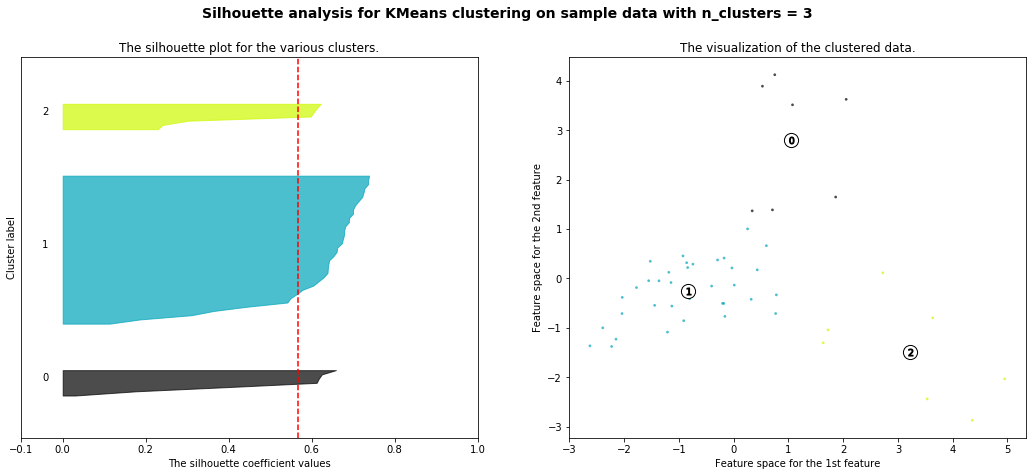

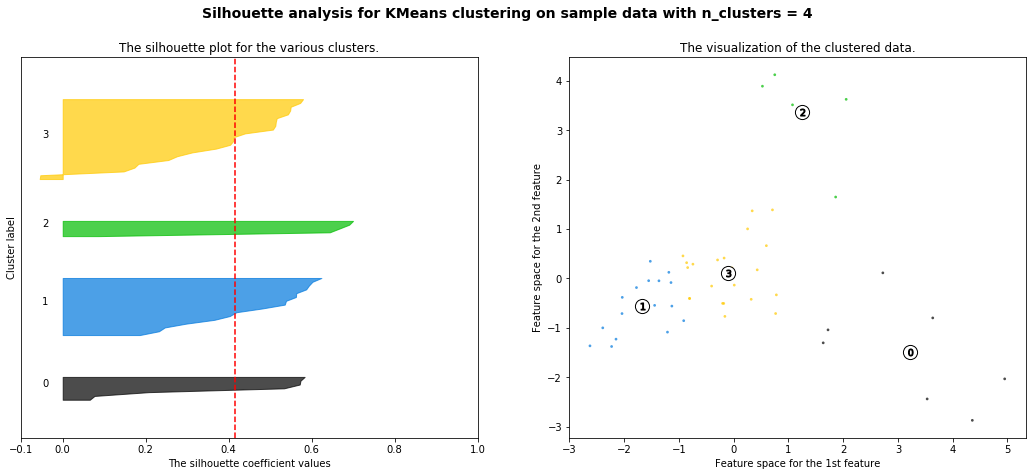

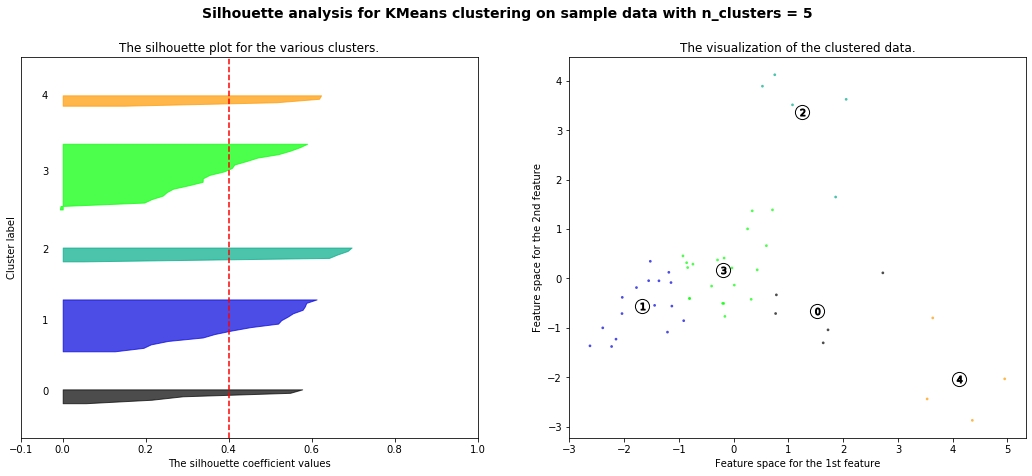

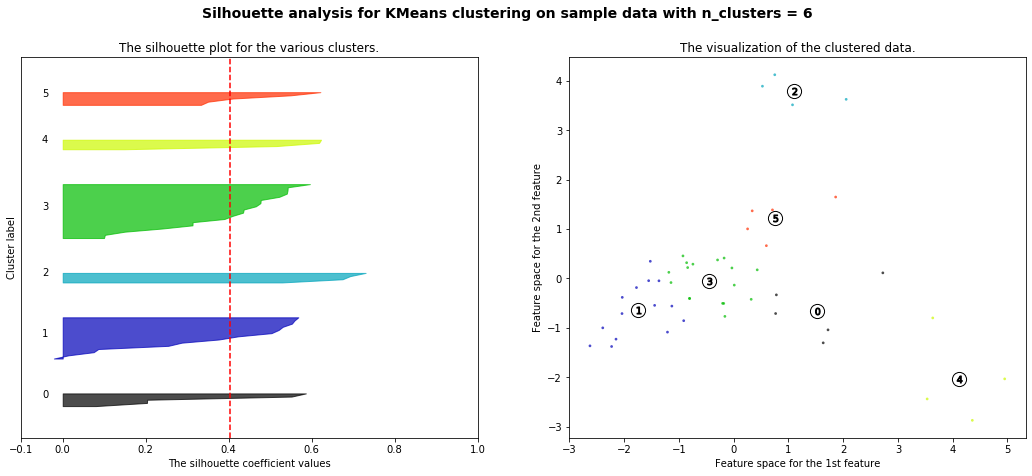

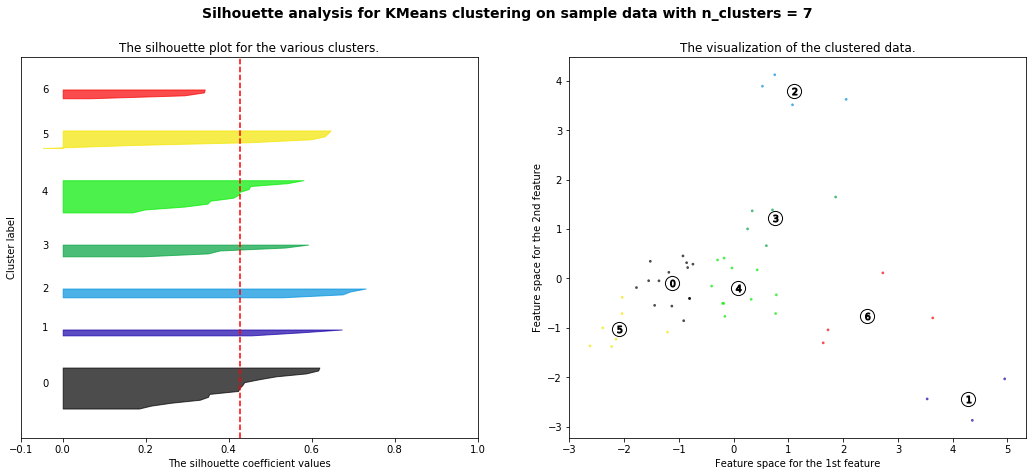

In [24]:
for i in range(3, 8):
    compute_kmeans(principalComponents, i)

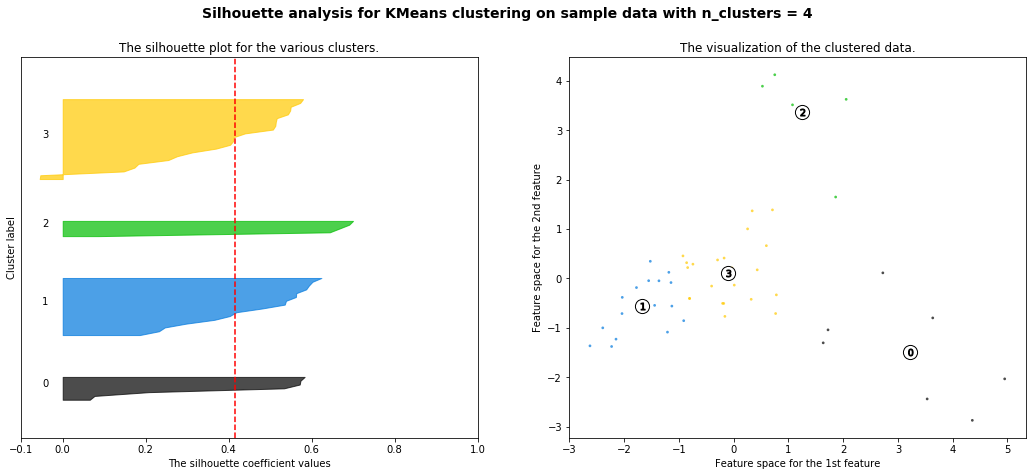

In [25]:
compute_kmeans(principalComponents, 4)

The mean shift algorithm selected three clusters, k-means also achieves its highest silhouette score when it divides the stations into three clusters. That said, I believe there will be value in breaking the largest of these clusters into two smaller ones as occurs when four clusters are selected. In order to confirm that the clusters produced with this parameter selection make sense we'll visualize the results below.

In [26]:
clusters=4
kmeans_object = KMeans(n_clusters = clusters, random_state=123)
kmeans_object.fit(std_df)
kmeans_clusters= kmeans_object.predict(std_df)
kmeans_result = pd.DataFrame({"labels":df.index, "kmeans_cluster":kmeans_clusters})
df['kmeans_cluster']=list(kmeans_result['kmeans_cluster'])

<a id='4.4. Results'></a>
****


# 4.4. Results

In [27]:
df_agg_COVID['cluster_number']=list(kmeans_result['kmeans_cluster'])

In [28]:
#create latitude and longitude columns in the ridership dataframe by referencing the "stations dataset"
lat = []
lon = []

# For each row in a varible,
for row in stations['Location']:
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[1])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[0])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
stations['latitude'] = lat
stations['longitude'] = lon

df_agg_COVID['latitude']=list(pd.to_numeric(stations['latitude']))
df_agg_COVID['longitude']=list(pd.to_numeric(stations['longitude']))

In [29]:
#create an interactive map with station that displays clusters by color and provides ridership data in popups 
SF_COORDINATES = (37.7749, -122.4194)
MAX_RECORDS = 1000
days_recorded=len(df_COVID.datetime.dt.date.unique())
  
# create empty map zoomed in on Denver
map = folium.Map(location=SF_COORDINATES, zoom_start=11)

for index, row in df_agg_COVID.iterrows():
    total_trip_count=row['total_trips']
    morning_commute=row['morning_commute']
    evening_commute=row['evening_commute']
    all_hours=row['morning_commute']+row['evening_commute']+row['after_hours']
    cluster_num=row['cluster_number']
    if row['cluster_number']==0:
        color="#0000FF"
    elif row['cluster_number']==1:
        color="#4C004C"
    elif row['cluster_number']==2:
        color="#FF00FF"        
    elif row['cluster_number']==3:
        color="#FFA500"        
    else:
        color='#FFFF00'
    folium.CircleMarker([row['latitude'], row['longitude']], radius=10, popup=f'{stations_dict[row.name].upper()} \n\n Cluster # {cluster_num}  \n\n Average Daily Trips:{int(total_trip_count/days_recorded)} \n Morning Commute:{"{:.2f}".format(round((morning_commute/all_hours*100), 2))}% \n Evening Commute:{"{:.2f}".format(round((evening_commute/all_hours*100), 2))}%', fill_color=color, fill_opacity=0.7).add_to(map)
    
display(map)

In [30]:
df_sorted=df.sort_values('kmeans_cluster')
for i in feature_list:
    fig = px.bar(df_sorted, x=df_sorted.index, y=i, color="kmeans_cluster", title=i)
    fig.show()

# Cluster Descriptions:

The plots above illustrate how k-means made its clustering decisions. The clusters can be summarized as follows:

## Cluster 0
These stations have moderate overall traffic with a majority of their users entering the station in the morning. These tend to be more residential areas.

## Cluster 1  
These stations have low overall trip counts with higher traffic during evening commute and after hours as well as weekends. Both the SF and Oakland airports are in this cluster as well two new stations at the end of the line that were opened in June of this year.

## Cluster 2  
These stations have moderate overall traffic with a higher than average number of their users entering the station in the evening. These tend to be in commercial areas such as Oakland City Center that have a higher concentration of business than the residential areas but less than the stations in cluster 3. 

## Cluster 3  
These stations have the highest overall traffic with a much higher percentage of their users entering the station during the evening commute. These stations are all in the northern corner of San Francisco that includes it's financial district. 

<a id='5. Time Series Analysis'></a>
****


# 5. Time Series Analysis

In [31]:
# read in 2020 data from dataframe dictionary
df=df_dict['df_2020']
df['datetime']=pd.to_datetime(df['datetime'])
df['datetime'] +=  pd.to_timedelta(df.hour, unit='h')
df=df.set_index('datetime')

In [32]:
def create_station_trips_df(df):
    join_df=df.groupby(df.index).sum()['trip_count'].to_frame()
    column_list=['All_Stations']
    for station in df['origin'].unique():
        #print(station)
        column_list.append(station)
        temp_df=df[df['origin']==station]
        temp_df=temp_df.groupby(temp_df.index).sum()['trip_count']
        join_df=join_df.join(temp_df.to_frame(), lsuffix='', rsuffix=station, how='outer')
    join_df.columns=column_list
    return join_df.fillna(0)

In [ ]:
# Create some additional features that extract data from the timestamp
df_stations=create_station_trips_df(df)
df_stations['temp_ts']=df_stations.index
df_stations['day']=df_stations['temp_ts'].dt.weekday
df_stations['hour']=df_stations['temp_ts'].dt.hour
df_stations['week']=df_stations['temp_ts'].dt.strftime('%Y-%W')
df_stations['date']=df_stations['temp_ts'].dt.strftime('%D')
# As discussed earlier, limit the dataset to samples taken after COVID-19 reduced ridership
df_stations=df_stations.loc['2020-04-12 00:00:00':]
df_stations['All_Stations'].plot()
plt.show()

<a id='5.1. ARIMA'></a>
****

# 5.1. ARIMA

In [ ]:
# Make a new dataset for our ARIMA analysis that only contains the needed features
df_ARIMA=pd.DataFrame()
for selected_station in df_stations:
    if selected_station not in ['temp_ts', 'day', 'hour', 'week', 'date']:
        df_ARIMA[selected_station]=df_stations.groupby('date').sum()[selected_station]

In order to select the p, d and q terms for our ARIMA model we will visualize the ways that the data is affected by differencing. This will give us an initial indication of what our p, d, and q terms should be. We will then use the auto-arima function to grid search the terms to determine the best selection.

## Determining D Value

In [ ]:
df_ARIMA['All_Stations'].plot(figsize=[20, 5])
plt.show()
df_ARIMA['All_Stations'].diff().plot(figsize=[20, 5])
plt.show()

The data appears to be rendered stationary after first order differencing. As an additional test, we will use the "ndiffs" function included in the pmdarima package. This function "perform(s) a test of stationarity for different levels of d to estimate the number of differences required to make a given time series stationary."

In [ ]:
for ndiff_test in ['adf', 'kpss', 'pp']:
    result=ndiffs(df_ARIMA['All_Stations'], test=ndiff_test)
    if result > 0:
        print(f"{ndiff_test.upper()} test indicates time series is rendered stationary by {result} differencing")
    else:
        print(f"{ndiff_test.upper()} test indicates time series is stationary without differencing")

Based on the results of these tests we can tentatively set our d term at 1, but the correct selection may in fact be 0. We will perform a grid search later to determine this.

## Using ACF to Determine Q Value

We find optimum features or order of the MA process (q value) using the ACF plot, being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot. 

In [ ]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
plt.rcParams.update({'figure.figsize':(25,16), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df_ARIMA['All_Stations']); axes[0, 0].set_title('Original Series')
plot_acf(df_ARIMA['All_Stations'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_ARIMA['All_Stations'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_ARIMA['All_Stations'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_ARIMA['All_Stations'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_ARIMA['All_Stations'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

The time series appears to be rendered stationary by first order differencing. Autocorrelations are relatively weak after the first differencing and additional orders of differencing cause the first lag to go strongly negative, an indication of over-differencing. It appears our q value should also be set at no more than 1.

## Using PACF to Determine P Value

We find optimum features or order of the AR process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_ARIMA['All_Stations']); axes[0].set_title('No Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_ARIMA['All_Stations'].dropna(), ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2)
axes[0].plot(df_ARIMA['All_Stations'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_ARIMA['All_Stations'].diff().dropna(), ax=axes[1])
plt.show()

First order differencing places the first lag (and all other lags) below the significance line, indicating we should not need to set our p term any greater than 1.

The analysis above indicates that the p,d and q terms should not need to be set higher than 1, the data is rendered stationary with the first level of differencing in all cases. In order to account for seasonality and determine the appropriate p,d, and q terms we will utilize the "auto_arima" function that grid searches the ARIMA terms to identify the order and seasonal order that results in the lowest AIC score.

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
split=int(df_ARIMA.shape[0]*.8)
train = df_ARIMA.All_Stations[:split]
test = df_ARIMA.All_Stations[split:]

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='kpss',       # use kpss to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # let model determine 'd'
                      seasonal=True,   
                      #start_P=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      m=7, # The period for seasonal differencing is sent to 1 week (7 days)
                      stepwise=True)

print(model.summary())

In [ ]:
model

The best performing model utilizes the order (0, 0, 1) and the seasonal order (1, 1, 1, 7). Lets take a look at the forecasting this model produces.

# Forecasting

This custom function builds an ARIMA model, forecasts one month out from the last date in the training set and visualizes the results.


In [ ]:
def BART_ARIMA(df, selected_station, number_of_forecasts=1, forecast_interval=7, return_results=False):
    results_dict={}
    for split in range(df.shape[0]-31+forecast_interval-7*number_of_forecasts ,df.shape[0], forecast_interval):
        train = df[selected_station][:split]
        test = df[selected_station][split:split+31]  
        #print('min date',test.index.min())
        if test.shape[0]<31:
            break
        # Build Model
        model=sm.tsa.statespace.SARIMAX(train, trend= 'ct', order=(0, 0, 1), seasonal_order=(0, 1, 1, 7), enforce_stationarity=False)
        fitted = model.fit(disp=False)

        # Forecast
        fc_series = fitted.forecast(test.index.shape[0], alpha=0.05)  # 95% conf
        fc_series=fc_series.clip(lower=0)
        fc_series.index=test.index

        # Plot
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(train, label='training')
        plt.plot(test, label='actual')
        plt.plot(fc_series, label='forecast')
        if selected_station in stations_dict:
            station_name=stations_dict[selected_station]
        else:
            station_name=selected_station
        plt.title(f'{station_name}\nARIMA One Month Forecast vs Actual Ridership\nForecast Starting {test.index.min()}')
        plt.legend(loc='upper left', fontsize=8)
        fig.tight_layout()
        plt.xticks([x for x in range(0, df.shape[0], 20)])
        plt.show()
        rms = np.sqrt(mean_squared_error(fc_series.iloc[:test.shape[0]], test))

        #y=test
        #pred=fc_series
        compare_df=pd.concat([test, fc_series], axis=1).dropna(how='any')
        compare_df.columns=['y', 'yhat']
        compare_df['error']=compare_df.y-compare_df.yhat
        compare_df['error_as_pct']=compare_df['error']/compare_df.y
        compare_df['error']=compare_df.y-compare_df.yhat
        compare_df['error_as_pct']=compare_df['error']/compare_df.y
        result=compare_df[(compare_df['error_as_pct']<.1) & (compare_df['error_as_pct']>-.1)].shape[0]/compare_df.shape[0]
        #compare_df['error_as_pct'].hist()
        print(f"Prediction is with in +/-10% for {(result*100):.2f}% of the predictions")
        #print(f'RMS score = {rms:.2f}\n\n\n') 
        results_dict.update({test.index.min():result})
    if return_results:
        return results_dict

In order to evaluate our ARIMA model I will make month-long forecasts starting from different points in the dataset. This will allow us to evaluate how well its predictions would have performed if we started deploying this model in May.

In [ ]:
ARIMA_results=BART_ARIMA(df_ARIMA, 'All_Stations', number_of_forecasts=8, return_results=True)
ARIMA_results

As can be see, ridership numbers had recovered fairly steadily until late June, at which point they began to experience a slow decline again. Part of my hypothesis had been that this recovery trend would be slow but steady. However, with "California and the Bay Area each reporting nearly 75% increases in daily cases in June compared to May" it appears ridership suffered [(SF Chronicle: Coronavirus surge brings fear of new shutdown)](https://www.sfchronicle.com/health/article/Coronavirus-experts-say-California-is-entering-a-15367494.php).

As a result of the ridership trend changing direction suddenly our ARIMA model overestimated ridership for late June and July. Let's look at individual stations to determine if the same issues exist there. We'll select one station from each of the cluster's we identified earlier.

In [ ]:
for station in ['DALY', 'SFIA', '12TH', 'CIVC']:
    BART_ARIMA(df_ARIMA, station, number_of_forecasts=1)

As can be seen the underestimation issue also exists for our station level forecasts. Let's see if Prophet performs any better.

<a id='5.2. Prophet'></a>
****

# 5.2. Prophet

In [ ]:
def BART_PROPHET(df, selected_station, number_of_forecasts=1, forecast_interval=7, prior_scale=0.05, return_results=False):
    df_prophet=df.groupby('date').sum()[selected_station].to_frame()
    results_dict={}
    for split in range(df_ARIMA.shape[0]-31+forecast_interval-7*number_of_forecasts ,df_ARIMA.shape[0], forecast_interval):
        logger = logging.getLogger()
        logger.setLevel(logging.CRITICAL)
        prophet_train = df_ARIMA.All_Stations[:split]
        prophet_test = df_ARIMA.All_Stations[split:split+31]  
        if prophet_test.shape[0]<31:
            break
        
        prophet_train=df_prophet[:split]
        prophet_test=df_prophet[split:]
        prophet_test.index = pd.to_datetime(prophet_test.index)

        prophet_train['ds']=prophet_train.index
        prophet_train.index = pd.to_datetime(prophet_train.index)
        prophet_train['y']=list(prophet_train[selected_station])
        prophet_train=prophet_train[['ds', 'y']]

        #m = Prophet(changepoint_prior_scale=.001).fit(prophet_train)
        m = Prophet(yearly_seasonality=False, changepoint_prior_scale=prior_scale).fit(prophet_train)

        future = m.make_future_dataframe(periods=30, freq='D')
        fcst = m.predict(future)

        matplotlib.rcParams.update({'font.size': 22})
        prophet_train['y'].plot(c='b')
        prophet_test[selected_station].plot(c='y', figsize=[30,10])
        #fcst.set_index('ds')['yhat'].plot(c='r')
        if selected_station in stations_dict:
            station_name=stations_dict[selected_station]
        else:
            station_name=selected_station
        fcst.set_index('ds')['yhat'].plot(c='r')
        plt.title(f'{station_name}\nProphet One Month Forecast vs Actual Ridership\nForecast Starting {prophet_test.index.min()}')
        plt.legend(['train', 'test', 'forecast'])
        plt.show()
        
        y=prophet_test[selected_station]
        pred=fcst.set_index('ds')['yhat']
        compare_df=pd.concat([y, pred], axis=1).dropna(how='any')
        compare_df.columns=['y', 'yhat']
        compare_df['error']=compare_df.y-compare_df.yhat
        compare_df['error_as_pct']=compare_df['error']/compare_df.y
        compare_df['error']=compare_df.y-compare_df.yhat
        compare_df['error_as_pct']=compare_df['error']/compare_df.y
        result=compare_df[(compare_df['error_as_pct']<.1) & (compare_df['error_as_pct']>-.1)].shape[0]/compare_df.shape[0]
        #compare_df['error_as_pct'].hist()
        print(f"Prediction is with in +/-10% for {(result*100):.2f}% of the predictions")
        results_dict.update({prophet_test.index.min():result})
    if return_results:
        return results_dict

In [ ]:
BART_PROPHET(df_stations, 'All_Stations', number_of_forecasts=8)

In [ ]:
for i in range(5, 500, 100):
    BART_PROPHET(df_stations, 'All_Stations', number_of_forecasts=1, prior_scale=i/1000)
    print(f'Change point prior scale was set to {i/1000}')

In [ ]:
Prophet_results=BART_PROPHET(df_stations, 'All_Stations', number_of_forecasts=8, prior_scale=.3, return_results=True)

In [ ]:
Prophet_results

In [ ]:
ARIMA_results

Adjusting the trend flexibility using Prophet's changepoint_prior_scale parameter did improve model performance, particularly for the most recent weeks that saw a sudden downturn in ridership. That said, this improved but did not eliminate the underestimation issue. Lets take a look at an individual station from each cluster we identified earlier.

In [ ]:
for station in ['DALY', 'SFIA', '12TH', 'CIVC']:
    BART_PROPHET(df_stations, station, number_of_forecasts=1)

Prophet also underestimates ridership at the station level, but again appears to perform better than ARIMA. Given its greater accuracy when analyzing the available data, as well as its ability to adjust trend flexibility (and thereby account changes in ridership trends) I would recommend implementing Prophet over ARIMA. 

<a id='6. Discussion and Recommendations'></a>
***

# 6. Discussion and Recommendations

<a id='6.1. Business Insights'></a>
***

# 6.1. Business Insights

Our analysis has provided insight into BART ridership during the COVID-19 pandemic. Starting in March ridership dropped drastically before beginning a slow recovery that stalled out in late June. Between June and mid-August ridership decreased again slightly. 

This most recent downturn in traffic was not well captured by our ARIMA or Prophet models, which expected to see a slow and steady recovery that adhered to the trend present in the April to early June data. Consequently I was unable to confirm my hypothesis that monthly forecasting could achieve +/-10% accuracy for at least 80% of its predictions.

Nevertheless our forecasting could prove to be a useful tool for making ridership projections if it is reasonable to expect this slow and steady recovery to resume. Management could use these forecasting tools along with domain knowledge to create staff schedules, schedule maintenance activities and estimate revenue.

<a id='6.2. Recommendations for Further Analysis'></a>
***

# 6.2. Recommendations for Further Analysis

The same forecasting we have developed could be extended to make long term predictions. For instance it could be used to forecast out several months and potentially help identify when ridership will return to pre-COVID levels (assuming current trends continue).

Regardless of how this forecasting is utilized it will need to be repeated at regular intervals. As we saw, the recovery trend is inconsistent enough that the model needs to be retrained periodically to maintain accurate predictions. The data we used is published monthly, which is why I choose to make monthly forecasts. The process of running these models when the new data becomes available could be automated through a Flask app.